In [1]:
import os
import numpy as np
from osgeo import gdal
%matplotlib inline
import matplotlib.pyplot as plt

def writeTiff(im_data,im_width,im_height,im_bands,im_geotrans,im_proj,path):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32

    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    elif len(im_data.shape) == 2:
        im_data = np.array([im_data])
    else:
        im_bands, (im_height, im_width) = 1,im_data.shape
        #创建文件
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, im_width, im_height, im_bands, datatype)
    if(dataset!= None):
        dataset.SetGeoTransform(im_geotrans) #写入仿射变换参数
        dataset.SetProjection(im_proj) #写入投影
    for i in range(im_bands):
        dataset.GetRasterBand(i+1).WriteArray(im_data[i])
    del dataset


In [11]:

#['slope','twi','pre_mean','b6_mean','savi_max','evi_max','ndvi_max']
path = r'G:\Hubei_SOM_MODIS_500m_prediction_2017\2000-2017_RF_test_SOM\GBRT\GBRT_som_change'
out_path = r'G:\Hubei_SOM_MODIS_500m_prediction_2017\2000-2017_RF_test_SOM\GBRT\GBRT_som_change'
#print(os.walk(path))
ds = gdal.Open(path+'//'+'som_p.tif')
ds1 = gdal.Open(path+'//'+'GBRT_Decrease_cropland_som_slope.tif')
ds2 = gdal.Open(path+'//'+'GBRT_Increase_cropland_som_slope.tif')
ds3 = gdal.Open(path+'//'+'GBRT_Unchanged_cropland_som_slope.tif')
tr = ds.GetGeoTransform()
prj = ds.GetProjection()
x1 = ds.RasterXSize
y1 = ds.RasterYSize
im_bands = ds.RasterCount #波段数
arr1 = ds1.ReadAsArray(0, 0, x1, y1)#.reshape(-1, 1)
arr2 = ds2.ReadAsArray(0, 0, x1, y1)
arr3 = ds3.ReadAsArray(0, 0, x1, y1)
arr = ds.ReadAsArray(0, 0, x1, y1)

print(arr.shape, arr1.shape)
print(x1, y1, im_bands,)

(825, 1509) (825, 1509)
1509 825 1


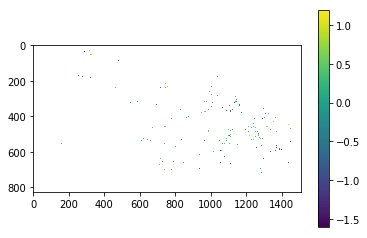

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
arr1[arr1<-100] = np.nan
arr1[arr!=0] = np.nan
plt.imshow(arr1)
plt.colorbar()
writeTiff(arr1, x1, y1, im_bands, tr, prj, out_path+'//'+'dec_sig.tif')


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(825, 1509)


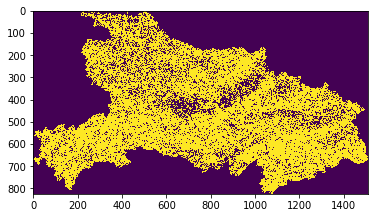

In [40]:
##rasterio 
##extract rif by mask
import fiona
import rasterio
import rasterio.mask

# open mask file
with fiona.open(r"G:\Hubei_SOM_MODIS_500m_prediction_2017\shp\HB_shp.shp", "r") as shapefile:##mask shp file
    features = [feature["geometry"] for feature in shapefile]
    

#open tif by masked
with rasterio.open(path+'//'+'som_p.tif') as src:#read raster file
    print(src.read(1))
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
    hight = out_image.shape[1]
    width = out_image.shape[2]
    out_meta = src.meta.copy()
    out_image= out_image[0,:,:]
    print(out_image.shape)
    out_image[out_image>0] = 255
    #out_image[arr>0] = 255
    plt.imshow(out_image[:,:])

     
out_image = out_image.reshape(1, 825, 1509)    
out_meta.update({"driver": "GTiff",
                 "height": hight,
                 'nodata':255,
                 "width": width,
                 "transform": out_transform})

#write the masked raster to a new file.

with rasterio.open( out_path+'//'+'p_value.tif', "w", **out_meta) as dest:#write raster file
    dest.write(out_image)

# There different methods to solve this problem.

In [6]:
int(-3.40282346639e+038)

-340282346639000000870967122248196947968